# **Installation**

In [1]:
import shap

import warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from scipy.stats import norm
from bokeh.io import export_svgs
from bokeh.layouts import row, gridplot
from bokeh.plotting import figure, show
from bokeh.palettes import viridis, cividis
from bokeh.models import ColumnDataSource, Range1d

# import optuna
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import StackingRegressor, GradientBoostingRegressor, AdaBoostRegressor, RandomForestRegressor, HistGradientBoostingRegressor
from lightgbm import LGBMRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import RidgeCV
from sklearn.pipeline import Pipeline
from sklearn.dummy import DummyRegressor
from sklearn.compose import ColumnTransformer
from sklearn.inspection import permutation_importance, PartialDependenceDisplay
from sklearn.preprocessing import OneHotEncoder, RobustScaler
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_predict, cross_val_score

import lazypredict
from lazypredict.Supervised import LazyRegressor

from textwrap import wrap
from matplotlib.cm import get_cmap

viridis_palette = viridis(256)

# **Data Import**

In [2]:
# Create a DataFrame from CSV data
df = pd.read_csv("strokes.csv")

# **Feature Engineering**

for putting add in:
- distance to pin - distance to edge
- distance to pin / distance to edge
- compare "Downhill Slope" and "Elevation below ball" for .corr() score

In [3]:
selected_columns = ['player_id', 'last_name', 'round','hole','hole_score','par_value','yardage', 'shot', 'shot_type', 'num_of_strokes',
       'from_location_scorer', 'from_location_laser', 'to_location_scorer',
       'to_location_laser', 'distance', 'distance_to_pin', 'in_the_hole',
       'around_the_green', 'first_putt', 'dist_to_hole_after_shot', 'time',
       'lie', 'elevation', 'slope', 'x', 'y', 'z', 'dist_from_center',
       'dist_from_edge']  # Add the column names you want to select
df = df[selected_columns].copy()

#inches to yards
df['distance_to_pin'] = df['distance_to_pin']/36

df['dist_to_hole_after_shot'] = df['dist_to_hole_after_shot']/36


In [4]:
df['lie_location'] =    np.where(df['dist_to_hole_after_shot'] == 0, 'Hole',
                        np.where(df['to_location_laser'].str.contains('Rough', case=False), 'Rough',
                        np.where(df['to_location_scorer'].str.contains('Rough', case=False), 'Rough',
                        np.where(df['to_location_scorer'].str.contains('Bunker', case=False), 'Bunker',
                        np.where(df['to_location_scorer'].str.contains('Green', case=False), 'Green',
                        np.where(df['to_location_laser'].str.contains('Fairway', case=False), 'Fairway',
                        np.where(df['to_location_scorer'].str.contains('Tree', case=False), 'Rough',
                        #np.where(df['dist_to_hole_after_shot'] == 0, 'Hole',
                        #distance_to_hole_after_the_shot == 0 ~ 'Hole',
                        np.where(df['to_location_scorer'].str.contains('Water', case=False), 'Water', 'Unknown'))))))))

# df = df[df['lie_location'] != 'Unknown']
df['round_hole_combination'] = (df['round'] - 1) * 18 + df['hole']

df['strokes_to_hole_out'] = df['hole_score'] - df['shot'] + df['num_of_strokes'] # df['num_of_strokes'] was 1
result_df = df # del aftee num_of_strokes test


#instead of 1, should be df['num_of_strokes']
#then shots after water mark as provisionals
#drop shots from water
#plot a out a water penalty hole just to check

# **Drop Holes with Penalties**

In [5]:
# df['flag_strokes_to_hole_out_1_or_less'] = df['strokes_to_hole_out'] <= 0

# selected_rows = df[df['flag_strokes_to_hole_out_1_or_less']]

# # Get the 'player_id' and 'round_hole_combination' for the selected rows
# players_to_remove = selected_rows[['player_id', 'round_hole_combination']]

# # Remove corresponding 'round_hole_combination' for each player
# result_df = df.merge(players_to_remove, on=['player_id', 'round_hole_combination'], how='left', indicator=True)
# result_df = result_df[result_df['_merge'] == 'left_only']

# # Drop the indicator column and reset the index
# result_df = result_df.drop(columns=['_merge']).reset_index(drop=True)

# **Drop Holes with Water or Unknown Lies**

In [6]:
# result_df['flag_water_or_unknown_lies'] = (result_df['lie_location'] == 'Water') | (result_df['lie_location'] == 'Unknown')

# selected_rows = result_df[result_df['flag_water_or_unknown_lies']]

# # Get the 'player_id' and 'round_hole_combination' for the selected rows
# players_to_remove = selected_rows[['player_id', 'round_hole_combination']]

# # Remove corresponding 'round_hole_combination' for each player
# result_df = result_df.merge(players_to_remove, on=['player_id', 'round_hole_combination'], how='left', indicator=True)
# result_df = result_df[result_df['_merge'] == 'left_only']

# # Drop the indicator column and reset the index
# result_df = result_df.drop(columns=['_merge']).reset_index(drop=True)

# **Drop Holes with Non Standards Shot Types**

In [7]:
# result_df['flag_non_standard_shot_types'] = result_df['shot_type'] != 'S'

# selected_rows = result_df[result_df['flag_non_standard_shot_types']]

# #-----

# # Get the 'player_id' and 'round_hole_combination' for the selected rows
# players_to_remove = selected_rows[['player_id', 'round_hole_combination']]

# # Remove corresponding 'round_hole_combination' for each player
# result_df = result_df.merge(players_to_remove, on=['player_id', 'round_hole_combination'], how='left', indicator=True)
# result_df = result_df[result_df['_merge'] == 'left_only']

# # Drop the indicator column and reset the index
# result_df = result_df.drop(columns=['_merge']).reset_index(drop=True)

In [8]:
# Shift all values in the 'column_name' down by one row
result_df['next_lie_location'] =  result_df['lie_location']

result_df['lie_location'] = result_df['lie_location'].shift(1)

result_df['lie_location'] =    np.where(result_df['shot'] == 1, 'Tee',result_df['lie_location'])

In [9]:
result_df['bad_strokes_to_hole_out_value_flag'] = (result_df['strokes_to_hole_out'] <= 0)

#looks like .iloc 1939 and 5731 are the only messed up holes so thats a W!
selected_rows = result_df[result_df['bad_strokes_to_hole_out_value_flag']]

# Get the 'player_id' and 'round_hole_combination' for the selected rows
players_to_remove = selected_rows[['player_id', 'round_hole_combination']]

# Remove corresponding 'round_hole_combination' for each player
result_df = result_df.merge(players_to_remove, on=['player_id', 'round_hole_combination'], how='left', indicator=True)
result_df = result_df[result_df['_merge'] == 'left_only']

# Drop the indicator column and reset the index
result_df = result_df.drop(columns=['_merge']).reset_index(drop=True)

In [10]:
result_df.to_csv('FE_golf.csv')

# **Distance to Pin vs Strokes to Hole Out**

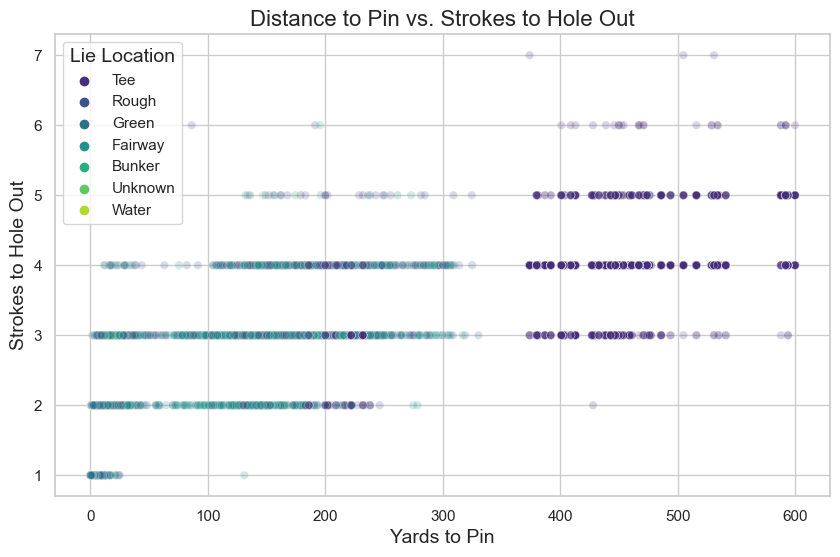

In [11]:
# Define a color palette
pal = {
    'Rough': '#006400',
    'Green': '#00FF00',
    'Fairway': '#008000',
    'Bunker': 'yellow',
    'Tee': 'black',
    'Water': 'blue',
    'Unknown':'brown'
}

# Set Seaborn style
sns.set(style='whitegrid')

# Create scatter plot with improved aesthetics
plt.figure(figsize=(10, 6))
scatter_plot = sns.scatterplot(x='distance_to_pin', y='strokes_to_hole_out',alpha=0.2, hue='lie_location', palette='viridis', data=result_df)

# Set plot title and labels
plt.title('Distance to Pin vs. Strokes to Hole Out', fontsize=16)
plt.xlabel('Yards to Pin', fontsize=14)
plt.ylabel('Strokes to Hole Out', fontsize=14)

# Customize legend
scatter_plot.legend(title='Lie Location', title_fontsize='14', loc='upper left')

# Show the plot
plt.show()

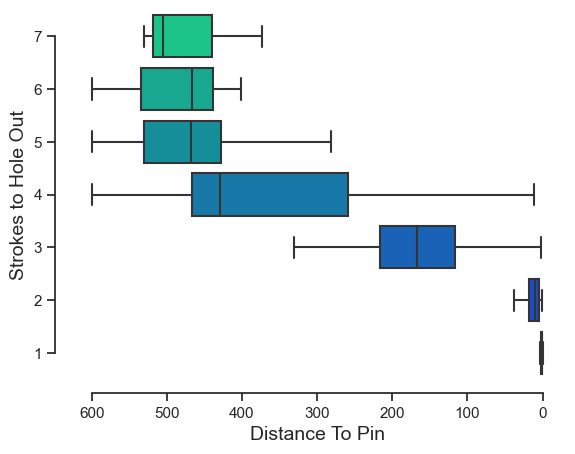

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set Seaborn style
sns.set_theme(style="ticks", palette="pastel")

# Load the example tips dataset
tips = sns.load_dataset("tips")

# Draw a horizontal nested boxplot to show bills by day and time
ax = sns.boxplot(y="strokes_to_hole_out", x="distance_to_pin",
            #hue="lie_location", 
            palette='winter',
            data=result_df,
            orient="h",
            showfliers=False)
sns.despine(offset=10, trim=True)
ax.invert_yaxis()
ax.invert_xaxis()

# Set labels
plt.xlabel('Distance To Pin', fontsize=14)
plt.ylabel('Strokes to Hole Out', fontsize=14)

# Show the plot
plt.show()


In [13]:
(result_df['strokes_to_hole_out'] == 0).sum()

0

https://docs.bokeh.org/en/latest/docs/examples/basic/annotations/whisker.html

https://docs.bokeh.org/en/latest/docs/examples/topics/categorical/ridgeplot.html

In [14]:
# just do a ridge line for distance to pin 1st or kde idh

# **Bin Distances to Pin**

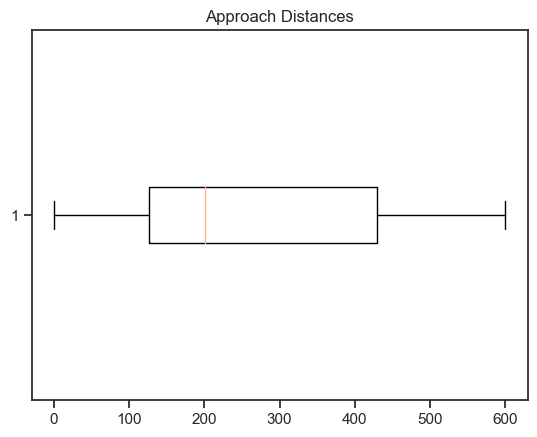

In [15]:
non_green_df = result_df[result_df['lie_location'] != 'Green']
plt.title('Approach Distances')
plt.boxplot(non_green_df['distance_to_pin'], vert=False)
plt.show()

In [16]:
bins =    [0,       150,       200,       300,       400, 600]
labels = ['0-150', '150-200', '200-300', '300-400', '400-650']

result_df['distance_bins'] = pd.cut(result_df['distance_to_pin'], bins=bins, labels=labels, right=False)
print(result_df['distance_bins'].isna().sum())
result_df['distance_bins'] = result_df['distance_bins'].cat.add_categories([''])
result_df['distance_bins'].fillna('', inplace=True)
print(result_df['distance_bins'].isna().sum())

29
0


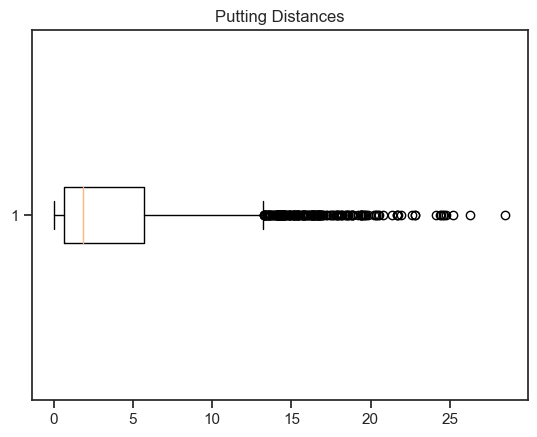

In [17]:
green_df = result_df[result_df['lie_location'] == 'Green']
plt.title('Putting Distances')
plt.boxplot(green_df['distance_to_pin'], vert=False)
plt.show()

In [18]:
bins =    [0, 1, 1.5, 2, 2.5, 3, 3.5, 4, 5, 6, 14, 30]
labels = ['0-1', '1-1.5', '1.5-2', '2-2.5', '2.5-3', '3-3.5', '3.5-4', '4-5', '5-6', '6-14', '14-30']

result_df['distance_bins_putting'] = pd.cut(result_df['distance_to_pin'], bins=bins, labels=labels, right=False)
print(result_df['distance_bins_putting'].isna().sum())
result_df['distance_bins_putting'] = result_df['distance_bins_putting'].cat.add_categories([''])
result_df['distance_bins_putting'].fillna('', inplace=True)
print(result_df['distance_bins_putting'].isna().sum())



3988
0


# **TODO**

# **Above worked great, so bin:**

# **dis to edge for putting**

In [19]:
#TODO

 # **dist to center for approach**

In [20]:
#TODO

# **Lazy Predict**

In [21]:
# numeric_features = ['distance_to_pin',"dist_from_center"]
# numeric_transformer = Pipeline(steps=[
#     ("scaler", RobustScaler())
# ])

# categorical_features = ["lie_location",'round','par_value','slope','elevation','lie']
# categorical_transformer = OneHotEncoder(handle_unknown="ignore")

# preprocessor = ColumnTransformer(transformers=[
#     ("num_transform", numeric_transformer, numeric_features),
#     ("cat_transform", categorical_transformer, categorical_features)
# ])

In [22]:
# feature_cols = ["lie_location",'round','par_value','slope','elevation','lie','distance_to_pin',"dist_from_center"]
# X = result_df.loc[:, feature_cols]

# target_cols = ['strokes_to_hole_out']
# y = result_df.loc[:, target_cols]

# X_train, X_valid, y_train, y_valid = train_test_split(X, y, train_size=0.95, test_size=0.05,random_state=42,stratify = X[['lie_location',"par_value"]])

In [23]:
# reg = LazyRegressor(verbose=0,ignore_warnings=False, custom_metric=None )

# models,predictions = reg.fit(X_train, X_valid, y_train.values.ravel(), y_valid.values.ravel())

In [24]:
# models

In [25]:
# predictions

# **Optuna**

Do this again once done with binning...

## *Do i Need to prune??**

In [26]:
# feature_cols = ["lie_location",'round','par_value','slope','elevation','lie','distance_to_pin',"dist_from_center"]
# X = result_df.loc[:, feature_cols]

# categorical_cols = ["lie_location",'round','par_value','slope','elevation','lie']
# X = pd.get_dummies(X, columns=categorical_cols, drop_first=True)

# target_cols = ['strokes_to_hole_out'] 
# y = result_df.loc[:, target_cols]

# # Extract the columns for stratification
# stratify_cols = ["lie_location", "par_value"]
# stratify_data = result_df[stratify_cols]

# # Split the data, using 'stratify_data' for stratification
# X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42, stratify=stratify_data)

# GradientBoostingRegressor

In [27]:
# def objective(trial):
#     params = {
#         "n_estimators": trial.suggest_int("n_estimators", 1, 400),
#         "learning_rate": trial.suggest_loguniform("learning_rate", 0.001, 0.1),
#         "max_depth": trial.suggest_int("max_depth", 3, 10),
#         "subsample": trial.suggest_uniform("subsample", 0.5, 1.0),
#         "min_samples_split": trial.suggest_int("min_samples_split", 2, 10),
#         "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 10),
#         "max_features": trial.suggest_uniform("max_features", 0.1, 1.0),
#     }

#     model = GradientBoostingRegressor(**params, random_state=42)

#     model.fit(X_train, y_train)
#     y_pred = model.predict(X_valid)

#     mse = mean_squared_error(y_valid, y_pred)
#     return mse

# # Create and run the Optuna study
# study = optuna.create_study(direction='minimize')
# study.optimize(objective, n_trials=1000, timeout=600)  # You can adjust the number of trials

# # Print the best hyperparameters
# print('Best trial:')
# best_trial = study.best_trial
# print('  Value: {:.4f}'.format(best_trial.value))
# print('  Params: ')
# for key, value in best_trial.params.items():
#     print('    {}: {}'.format(key, value))


In [28]:
# import optuna.visualization as ov

In [29]:
# ov.plot_param_importances(study)


In [30]:
# ov.plot_contour(study, params=["n_estimators", "max_features"])


# LGBMRegressor

In [31]:
# def objective(trial):
#     params = {
#         "n_estimators": trial.suggest_int("n_estimators", 100, 1000),
#         "learning_rate": trial.suggest_loguniform("learning_rate", 0.001, 0.1),
#         "max_depth": trial.suggest_int("max_depth", 3, 10),
#         "subsample": trial.suggest_uniform("subsample", 0.5, 1.0),
#         "colsample_bytree": trial.suggest_uniform("colsample_bytree", 0.5, 1.0),
#         "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
#         "reg_alpha": trial.suggest_loguniform("reg_alpha", 1e-8, 10.0),
#         "reg_lambda": trial.suggest_loguniform("reg_lambda", 1e-8, 10.0),
#     }

#     model = LGBMRegressor(**params, random_state=42)

#     model.fit(X_train, y_train)
#     y_pred = model.predict(X_valid)

#     mse = mean_squared_error(y_valid, y_pred)
#     return mse

# # Create and run the Optuna study
# study = optuna.create_study(direction='minimize')
# study.optimize(objective, n_trials=100, timeout=600)  # You can adjust the number of trials

# # Print the best hyperparameters
# print('Best trial:')
# best_trial = study.best_trial
# print('  Value: {:.4f}'.format(best_trial.value))
# print('  Params: ')
# for key, value in best_trial.params.items():
#     print('    {}: {}'.format(key, value))

# AdaBoostRegressor

In [32]:
# def objective(trial):
#     params = {
#         "n_estimators": trial.suggest_int("n_estimators", 50, 500),
#         "learning_rate": trial.suggest_loguniform("learning_rate", 0.001, 1.0),
#         # Add any other relevant hyperparameters for AdaBoostRegressor
#     }

#     model = AdaBoostRegressor(**params, random_state=42)

#     model.fit(X_train, y_train)
#     y_pred = model.predict(X_valid)

#     mse = mean_squared_error(y_valid, y_pred)
#     return mse

# # Create and run the Optuna study
# study = optuna.create_study(direction='minimize')
# study.optimize(objective, n_trials=100, timeout=600)  # You can adjust the number of trials

# # Print the best hyperparameters
# print('Best trial:')
# best_trial = study.best_trial
# print('  Value: {:.4f}'.format(best_trial.value))
# print('  Params: ')
# for key, value in best_trial.params.items():
#     print('    {}: {}'.format(key, value))


# RandomForestRegressor

In [33]:
# def objective(trial):
#     params = {
#         "n_estimators": trial.suggest_int("n_estimators", 50, 500),
#         "max_depth": trial.suggest_int("max_depth", 3, 20),
#         "min_samples_split": trial.suggest_int("min_samples_split", 2, 10),
#         "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 10),
#         "max_features": trial.suggest_uniform("max_features", 0.1, 1.0),
#     }

#     model = RandomForestRegressor(**params, random_state=42)

#     model.fit(X_train, y_train)
#     y_pred = model.predict(X_valid)

#     mse = mean_squared_error(y_valid, y_pred)
#     return mse

# # Create and run the Optuna study
# study = optuna.create_study(direction='minimize')
# study.optimize(objective, n_trials=100, timeout=600)  # You can adjust the number of trials

# # Print the best hyperparameters
# print('Best trial:')
# best_trial = study.best_trial
# print('  Value: {:.4f}'.format(best_trial.value))
# print('  Params: ')
# for key, value in best_trial.params.items():
#     print('    {}: {}'.format(key, value))

# MLPRegressor

In [34]:
# def objective(trial):
#     params = {
#         "hidden_layer_sizes": trial.suggest_int("hidden_layer_sizes", 1, 100),
#         "alpha": trial.suggest_loguniform("alpha", 1e-6, 1.0),
#         "learning_rate_init": trial.suggest_loguniform("learning_rate_init", 1e-5, 1e-1),
#         "max_iter": trial.suggest_int("max_iter", 100, 1000),
#     }

#     model = MLPRegressor(**params, random_state=42)

#     model.fit(X_train, y_train.values.ravel())  # Note: MLPRegressor expects a 1D array for the target variable
#     y_pred = model.predict(X_valid)

#     mse = mean_squared_error(y_valid, y_pred)
#     return mse

# # Create and run the Optuna study
# study = optuna.create_study(direction='minimize')
# study.optimize(objective, n_trials=100, timeout=600)  # You can adjust the number of trials

# # Print the best hyperparameters
# print('Best trial:')
# best_trial = study.best_trial
# print('  Value: {:.4f}'.format(best_trial.value))
# print('  Params: ')
# for key, value in best_trial.params.items():
#     print('    {}: {}'.format(key, value))


# Optuna for Final Estimator's Meta Model

In [35]:
# # Assuming you have X_train, X_valid, y_train, y_valid defined

# # Define your base models
# base_models = [
#     ("GradientBoostingRegressor_pipeline", GradientBoostingRegressor(
#         n_estimators=298,
#         learning_rate= 0.017565096916826627,
#         max_depth= 4,
#         subsample= 0.9480233926615609,
#         min_samples_split= 9,
#         min_samples_leaf= 3,
#         max_features= 0.8625158448136574
#     )),
#     ("LGBMRegressor_pipeline", LGBMRegressor(
#         n_estimators= 442,
#         learning_rate= 0.009437712702673798,
#         max_depth= 4,
#         subsample= 0.6659162524367865,
#         colsample_bytree= 0.7446478198020141,
#         min_child_samples= 6,
#         reg_alpha= 6.32482216734694e-05,
#         reg_lambda= 0.001956292371616008)),
#     ("AdaBoostRegressor_pipeline", AdaBoostRegressor( 
#         n_estimators= 498,
#         learning_rate= 0.013946367159574381)),
#     ("RandomForestRegressor_pipeline", RandomForestRegressor(
#             n_estimators= 347,
#             max_depth= 7,
#             min_samples_split= 10,
#             min_samples_leaf= 7,
#             max_features= 0.5624136409317273)),
#     ("MLPRegressor_pipeline", MLPRegressor(
#       hidden_layer_sizes= 61,
#       alpha= 0.0016007134120975964,
#       learning_rate_init= 0.0002972290214448905,
#       max_iter= 226))
# ]

# # Create the stack model with fixed base models
# stack_model = StackingRegressor(estimators=base_models, final_estimator=GradientBoostingRegressor())

# def objective(trial):
#     # Define hyperparameters for the final estimator (meta-model)
#     meta_params = {
#         "n_estimators": trial.suggest_int("n_estimators", 100, 1000),
#         "learning_rate": trial.suggest_loguniform("learning_rate", 0.001, 0.1),
#         "max_depth": trial.suggest_int("max_depth", 3, 10),
#         "subsample": trial.suggest_uniform("subsample", 0.5, 1.0),
#         "min_samples_split": trial.suggest_int("min_samples_split", 2, 10),
#         "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 10),
#         "max_features": trial.suggest_uniform("max_features", 0.1, 1.0)
#     }

#     # Create a new instance of GradientBoostingRegressor with tuned hyperparameters
#     final_estimator = GradientBoostingRegressor(**meta_params)

#     # Set the new final estimator in the stack model
#     stack_model.final_estimator = final_estimator

#     # Fit the stack model on the training data
#     stack_model.fit(X_train, y_train.values.ravel())

#     # Make predictions on the validation data
#     preds = stack_model.predict(X_valid)

#     # Evaluate the model using mean squared error
#     mse = mean_squared_error(y_valid, preds)
#     return mse

# # Create and run the Optuna study
# study = optuna.create_study(direction='minimize')
# study.optimize(objective, n_trials=100, timeout=600)  # You can adjust the number of trials

# # Print the best hyperparameters
# print('Best trial:')
# best_trial = study.best_trial
# print('  Value: {:.4f}'.format(best_trial.value))
# print('  Params: ')
# for key, value in best_trial.params.items():
#     print('    {}: {}'.format(key, value))


# #result:
# '''
# Best trial:
#   Value: 0.1813
#   Params: 
#     n_estimators: 273
#     learning_rate: 0.03887266282764213
#     max_depth: 3
#     subsample: 0.81654345269596
#     min_samples_split: 7
#     min_samples_leaf: 10
#     max_features: 0.5767799915192618
# '''


# **Shap**

In [36]:
numeric_features = ['distance_to_pin','dist_from_edge']
numeric_transformer = Pipeline(steps=[
    ("scaler", RobustScaler())
])

categorical_features =  ['slope','elevation']
categorical_transformer = OneHotEncoder(handle_unknown="ignore")

preprocessor = ColumnTransformer(transformers=[
    ("num_transform", numeric_transformer, numeric_features),
    ("cat_transform", categorical_transformer, categorical_features)
])

result_df_green = result_df[result_df['lie_location'] == 'Green']


# took out 'hole'
feature_cols = ['distance_to_pin','dist_from_edge','slope','elevation','distance_bins_putting']
X = result_df_green.loc[:, feature_cols]

target_cols = ['strokes_to_hole_out']
y = result_df_green.loc[:, target_cols]

X_train, X_valid, y_train, y_valid = train_test_split(X, y, train_size=0.8, test_size=0.2,random_state=42)

X_train_preprocessed = preprocessor.fit_transform(X_train)
X_valid_preprocessed = preprocessor.transform(X_valid)

ter_xg = GradientBoostingRegressor(
    n_estimators=298,
    learning_rate= 0.017565096916826627,
    max_depth= 4,
    subsample= 0.9480233926615609,
    min_samples_split= 9,
    min_samples_leaf= 3,
    max_features= 0.8625158448136574
).fit(X_train_preprocessed, y_train.values.ravel())

# Get feature names after one-hot encoding
encoded_feature_names = list(preprocessor.named_transformers_['cat_transform'].get_feature_names_out(categorical_features))

# Combine numeric and encoded feature names
all_feature_names = numeric_features + encoded_feature_names

explainer = shap.TreeExplainer(ter_xg)

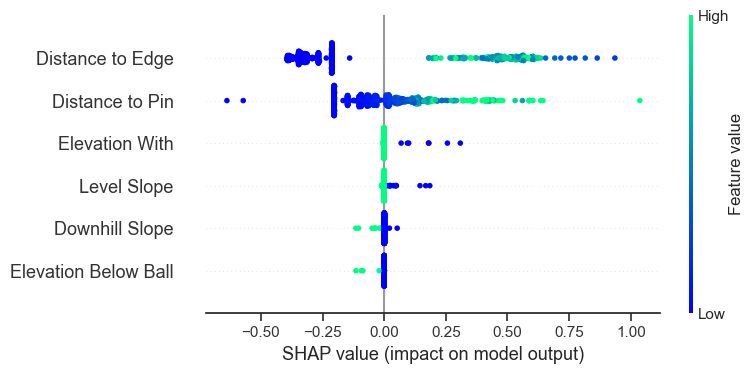

In [37]:

shap_values = explainer(X_valid_preprocessed)

shap.initjs()


all_feature_names_2 = all_feature_names
all_feature_names_2[0] = 'Distance to Pin'
all_feature_names_2[1] = 'Distance to Edge'
all_feature_names_2[2] = 'Downhill Slope'
all_feature_names_2[3] = 'Level Slope'
all_feature_names_2[4] = 'Unknown Slope'
all_feature_names_2[5] = 'Uphill Slope'
all_feature_names_2[6] = 'Elevation Above Ball'
all_feature_names_2[7] = 'Elevation Below Ball'
all_feature_names_2[8] = 'Elevation Unknown'
all_feature_names_2[9] = 'Elevation With'
# Create SHAP summary plot with feature names
#winter
shap.summary_plot(shap_values, X_valid_preprocessed, feature_names=all_feature_names_2, cmap = 'winter', max_display=6)#,show=False)
# plt.savefig('shap_summary_plot_3.svg', format='svg')


# **SG Stack Putting Model**

In [38]:
putting_numeric_features = ['distance_to_pin','dist_from_edge']
numeric_transformer = Pipeline(steps=[
    ("scaler", RobustScaler())
])

putting_categorical_features = ['slope','elevation','distance_bins_putting']
categorical_transformer = OneHotEncoder(handle_unknown="ignore")

putting_preprocessor = ColumnTransformer(transformers=[
    ("num_transform", numeric_transformer, putting_numeric_features),
    ("cat_transform", categorical_transformer, putting_categorical_features)
])

green_df = result_df[result_df['lie_location'] == 'Green']

feature_cols = ['slope','elevation','distance_to_pin','distance_bins_putting','dist_from_edge']
X = green_df.loc[:, feature_cols]

target_cols = ['strokes_to_hole_out']
y = green_df.loc[:, target_cols]

putting_X_train, putting_X_valid, putting_y_train, putting_y_valid = train_test_split(X, y, train_size=0.85, test_size=0.15,random_state=42,stratify = X[['distance_bins_putting']])

In [39]:
# feature_cols = ['slope','elevation','distance_to_pin']
# X = green_df.loc[:, feature_cols]

# categorical_cols = ['slope','elevation']
# X = pd.get_dummies(X, columns=categorical_cols, drop_first=True)

# target_cols = ['strokes_to_hole_out'] 
# y = green_df.loc[:, target_cols]

# # Extract the columns for stratification
# stratify_cols = ['slope','elevation']
# stratify_data = green_df[stratify_cols]

# # Split the data, using 'stratify_data' for stratification
# putting_X_train, putting_X_valid, putting_y_train, putting_y_valid  = train_test_split(X, y, test_size=0.2, random_state=42, stratify=stratify_data)

In [40]:
#Putting Putting Putting

#1
GradientBoostingRegressor_pipeline = Pipeline(steps=[(
    "preprocesser", putting_preprocessor), 
    ("GradientBoostingRegressor_pipeline", GradientBoostingRegressor(
        n_estimators=286,
        learning_rate= 0.01981634618847298,
        max_depth= 5,
        subsample= 0.9240470863832018,
        min_samples_split= 10,
        min_samples_leaf= 1,
        max_features= 0.6070414161555119
    ))])

#2

#Optuna Results
LGBMRegressor_pipeline = Pipeline(steps=[
    ("preprocessor", putting_preprocessor), 
    ("LGBMRegressor_pipeline", LGBMRegressor(
        n_estimators=463,
        learning_rate=0.09827919329551392,
        max_depth=5,
        subsample=0.5856953536670598,
        colsample_bytree=0.9504918763968095,
        min_child_samples=6,
        reg_alpha=5.070474210480463,
        reg_lambda=1.9254404262179434e-06
    ))
])

#Optuna Results
AdaBoostRegressor_pipeline = Pipeline(steps=[(
    "preprocesser", putting_preprocessor), 
    ("AdaBoostRegressor_pipeline", AdaBoostRegressor( 
        n_estimators= 246,
        learning_rate= 0.0024297994462212564))])

RandomForestRegressor_pipeline = Pipeline(steps=[
    ("preprocessor", putting_preprocessor), 
    ("RandomForestRegressor_pipeline", RandomForestRegressor(
        n_estimators=431,
        max_depth=6,
        min_samples_split=10,
        min_samples_leaf=1,
        max_features=0.7429990460692442
    ))
])

#6
MLPRegressor_pipeline = Pipeline(steps=[(
    "preprocesser", putting_preprocessor), 
    ("MLPRegressor_pipeline", MLPRegressor(
      hidden_layer_sizes= 31,
      alpha= 0.007143767710608828,
      learning_rate_init= 0.09007633815423446,
      max_iter= 803
    ))])

In [41]:
# Define your base models
base_models = [('GradientBoostingRegressor_pipeline', GradientBoostingRegressor_pipeline),
               ('LGBMRegressor_pipeline',LGBMRegressor_pipeline),
               ('AdaBoostRegressor_pipeline', AdaBoostRegressor_pipeline),
               ('RandomForestRegressor_pipeline', RandomForestRegressor_pipeline),
               ('MLPRegressor_pipeline', MLPRegressor_pipeline)]

# Define the meta-model
meta_model = GradientBoostingRegressor(
        n_estimators=286,
        learning_rate= 0.01981634618847298,
        max_depth= 5,
        subsample= 0.9240470863832018,
        min_samples_split= 10,
        min_samples_leaf= 1,
        max_features= 0.6070414161555119
)

# Create the stack model
stack_model_putting = StackingRegressor(estimators=base_models, final_estimator=meta_model)

# Fit the stack model on the training data
stack_model_putting.fit(putting_X_train, putting_y_train.values.ravel())

# Make predictions on the validation data
preds = stack_model_putting.predict(putting_X_valid)

# Extract the predicted distances
predicted_distance = list(preds)
actual_distance = putting_y_valid['strokes_to_hole_out'].to_list()


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000205 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 532
[LightGBM] [Info] Number of data points in the train set: 2959, number of used features: 19
[LightGBM] [Info] Start training from score 1.423116
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further spli

**Residuals**

In [42]:
final_pipe_results = pd.DataFrame()

final_pipe_results['predicted_distance'] = predicted_distance

final_pipe_results['actual_distance'] = actual_distance

final_pipe_results['residual'] = final_pipe_results['actual_distance'] - final_pipe_results['predicted_distance']

p = figure(height=300, width=300,title="Predicted vs Actual")
p.circle(actual_distance, predicted_distance, size=5, line_color=viridis_palette[180], fill_color=viridis_palette[180], fill_alpha=0.3)
p.xaxis.axis_label = 'Actual'
p.yaxis.axis_label = 'Predicted'

z = figure(height=300, width=300,title="Predicted vs Residual")
z.circle(final_pipe_results.residual, final_pipe_results.predicted_distance, size=5, line_color=viridis_palette[180], fill_color=viridis_palette[180], fill_alpha=0.3)
z.yaxis.axis_label = 'Predicted'
z.xaxis.axis_label = 'Residual'

b = figure(width=600, height=300, toolbar_location=None,
           title="Normality of Residuals")

# Histogram
bins = np.linspace(-0.5, 0.5, 100)
hist, edges = np.histogram(final_pipe_results.residual, density=True, bins=bins)
b.quad(top=hist, bottom=0, left=edges[:-1], right=edges[1:],
         fill_color=viridis_palette[180], line_color="white")

b.y_range.start = 0
b.x_range.start = -0.5
b.x_range.end = 0.5

b.xaxis.axis_label = "Residuals"
b.yaxis.axis_label = "Distribution Count"

grid = gridplot([[row(p,z)], 
                 [b]])
show(grid)

**[Permutaion Importance](https://scikit-learn.org/stable/modules/generated/sklearn.inspection.permutation_importance.html)**

In [43]:
# result = permutation_importance(stack_model_putting, 
#                                 putting_X_train, 
#                                 putting_y_train.values.ravel(), 
#                                 n_repeats=10,
#                                 random_state=42)

# # Your existing code for permutation importance calculation

# fig, ax = plt.subplots(figsize=(10, 8))  # Adjust size for better readability and aesthetics

# perm_sorted_idx = result.importances_mean.argsort()

# # Customize boxplot appearance
# box = ax.boxplot(
#     result.importances[perm_sorted_idx].T,
#     vert=False,
#     patch_artist=True,  # Enable filling colors
#     boxprops=dict(facecolor=viridis_palette[180], color=viridis_palette[180]),  # Box color customization
#     whiskerprops=dict(color='black'),  # Whisker color customization
#     capprops=dict(color='black'),  # Cap color customization
#     medianprops=dict(color='red')  # Median line color customization
# )

# # Set labels and title
# ax.set_yticklabels(putting_X_train.columns[perm_sorted_idx])
# ax.set_xlabel('Importance')
# ax.set_ylabel('Feature')
# ax.set_title('Permutation Importance')

# # Add a grid for better readability
# ax.grid(True, linestyle='--', alpha=0.7)

# # Add a vertical line at x=0
# ax.axvline(x=0, color="black", linestyle="--")

# # Customize layout
# plt.tight_layout()

# plt.show()

In [44]:
# putting_test = putting_X_valid.iloc[9]

# putting_Predictions = []
# list_of_putting_distances = [round(x * 0.1, 1) for x in range(0, 61)]
# f = putting_test
# input = f.to_frame().T

# for i in list_of_putting_distances:
#     input['distance_to_pin'] = i
#     preds = stack_model_putting.predict(input)
#     putting_Predictions.append(preds[0])

# plt.scatter(list_of_putting_distances, putting_Predictions, color='green', label='Scatter Plot')

# coefficients = np.polyfit(list_of_putting_distances, putting_Predictions, 2)
# poly_line = np.poly1d(coefficients)
# plt.plot(list_of_putting_distances, poly_line(list_of_putting_distances), color='red', label='Best Fit Line')
# plt.xlabel('Putting Distances (Yards)', fontsize=14, fontweight='bold', color='#2c3e50')  # Dark blue for the label
# plt.ylabel('xS', fontsize=14, fontweight='bold', color='#2c3e50')
# plt.title('Putting Distance vs xS', fontsize=18, fontweight='bold', color='#2c3e50')  # Larger title with dark blue color
# plt.show()

# putting_test

# **SG Stack *NON* Putting Model**

In [45]:
numeric_features = ['distance_to_pin','dist_from_center','dist_from_edge']
numeric_transformer = Pipeline(steps=[
    ("scaler", RobustScaler())
])

categorical_features = ["lie_location",'round','par_value','slope','elevation']
categorical_transformer = OneHotEncoder(handle_unknown="ignore")

preprocessor = ColumnTransformer(transformers=[
    ("num_transform", numeric_transformer, numeric_features),
    ("cat_transform", categorical_transformer, categorical_features)
])

result_df_no_green = result_df[result_df['lie_location'] != 'Green']


# took out 'hole'
feature_cols = ["lie_location",'round','par_value','slope','elevation','lie','distance_to_pin',"dist_from_center", 'distance_bins','dist_from_edge']
X = result_df_no_green.loc[:, feature_cols]

target_cols = ['strokes_to_hole_out']
y = result_df_no_green.loc[:, target_cols]

X_train, X_valid, y_train, y_valid = train_test_split(X, y, train_size=0.8, test_size=0.2,random_state=42,stratify = X[['distance_bins']])
X_train = X_train.drop(columns=['distance_bins'])
X_valid = X_valid.drop(columns=['distance_bins'])
y_train
# y_train = y_train.drop(columns=['distance_bins'])
# y_valid = y_valid.drop(columns=['distance_bins'])

# X_train_temp, X_valid_temp, y_train, y_valid = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state=42, stratify= X[['distance_bins']])
# y_train = y_train.drop(columns=['distance_bins'])
# y_valid = y_valid.drop(columns=['distance_bins'])
# # Drop the 'distance_bins' column from the training and testing datasets
# X_train = X_train_temp.drop(columns=['distance_bins'])
# X_valid = X_valid_temp.drop(columns=['distance_bins'])

,strokes_to_hole_out
365,2
2374,4
4767,4
2296,3
581,2
...,...
7136,4
6961,3
5945,2
3349,3


In [46]:
#1

#Optuna Results:
'''
Best trial:
  Value: 0.1766
  Params: 
    n_estimators: 298
    learning_rate: 0.017565096916826627
    max_depth: 4
    subsample: 0.9480233926615609
    min_samples_split: 9
    min_samples_leaf: 3
    max_features: 0.8625158448136574
'''
GradientBoostingRegressor_pipeline = Pipeline(steps=[(
    "preprocesser", preprocessor), 
    ("GradientBoostingRegressor_pipeline", GradientBoostingRegressor(
        n_estimators=298,
        learning_rate= 0.017565096916826627,
        max_depth= 4,
        subsample= 0.9480233926615609,
        min_samples_split= 9,
        min_samples_leaf= 3,
        max_features= 0.8625158448136574
    ))])

#2

#Optuna Results
'''
Best trial:
  Value: 0.1772
  Params: 
    n_estimators: 442
    learning_rate: 0.009437712702673798
    max_depth: 4
    subsample: 0.6659162524367865
    colsample_bytree: 0.7446478198020141
    min_child_samples: 6
    reg_alpha: 6.32482216734694e-05
    reg_lambda: 0.001956292371616008
'''
LGBMRegressor_pipeline = Pipeline(steps=[(
    "preprocesser", preprocessor), 
    ("LGBMRegressor_pipeline", LGBMRegressor(
        n_estimators= 442,
        learning_rate= 0.009437712702673798,
        max_depth= 4,
        subsample= 0.6659162524367865,
        colsample_bytree= 0.7446478198020141,
        min_child_samples= 6,
        reg_alpha= 6.32482216734694e-05,
        reg_lambda= 0.001956292371616008))])

#Optuna Results
'''
Best trial:
  Value: 0.1901
  Params: 
    n_estimators: 498
    learning_rate: 0.013946367159574381
'''
AdaBoostRegressor_pipeline = Pipeline(steps=[(
    "preprocesser", preprocessor), 
    ("AdaBoostRegressor_pipeline", AdaBoostRegressor( 
        n_estimators= 498,
        learning_rate= 0.013946367159574381))])

#5

#Optuna Results
'''
Best trial:
  Value: 0.1767
  Params: 
    n_estimators: 347
    max_depth: 7
    min_samples_split: 10
    min_samples_leaf: 7
    max_features: 0.5624136409317273
'''
RandomForestRegressor_pipeline = Pipeline(steps=[(
    "preprocesser", preprocessor), 
    ("RandomForestRegressor_pipeline", RandomForestRegressor(
            n_estimators= 347,
            max_depth= 7,
            min_samples_split= 10,
            min_samples_leaf= 7,
            max_features= 0.5624136409317273
    ))])

#6

#Optuna Results
'''
Best trial:
  Value: 0.1900
  Params: 
    hidden_layer_sizes: 61
    alpha: 0.0016007134120975964
    learning_rate_init: 0.0002972290214448905
    max_iter: 226
'''
MLPRegressor_pipeline = Pipeline(steps=[(
    "preprocesser", preprocessor), 
    ("MLPRegressor_pipeline", MLPRegressor(
      hidden_layer_sizes= 61,
      alpha= 0.0016007134120975964,
      learning_rate_init= 0.0002972290214448905,
      max_iter= 226
    ))])

In [47]:
# Define your base models
base_models = [('GradientBoostingRegressor_pipeline', GradientBoostingRegressor_pipeline),
               ('LGBMRegressor_pipeline',LGBMRegressor_pipeline),
            # idk why hist wants sparse data, no optuna for now
            # ('HistGradientBoostingRegressor_pipeline', HistGradientBoostingRegressor_pipeline),
               ('AdaBoostRegressor_pipeline', AdaBoostRegressor_pipeline),
               ('RandomForestRegressor_pipeline', RandomForestRegressor_pipeline),
               ('MLPRegressor_pipeline', MLPRegressor_pipeline)]

# Define the meta-model
meta_model = GradientBoostingRegressor(
    n_estimators= 273,
    learning_rate= 0.03887266282764213,
    max_depth= 3,
    subsample= 0.81654345269596,
    min_samples_split= 7,
    min_samples_leaf= 10,
    max_features= 0.5767799915192618
)

# Create the stack model
stack_model = StackingRegressor(estimators=base_models, final_estimator=meta_model)

# Fit the stack model on the training data
stack_model.fit(X_train, y_train.values.ravel())

# Make predictions on the validation data
preds = stack_model.predict(X_valid)

# Extract the predicted distances
predicted_distance = list(preds)
actual_distance = y_valid['strokes_to_hole_out'].to_list()


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000170 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 801
[LightGBM] [Info] Number of data points in the train set: 3750, number of used features: 21
[LightGBM] [Info] Start training from score 3.310667
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

**Residuals**

In [48]:
final_pipe_results = pd.DataFrame()

final_pipe_results['predicted_distance'] = predicted_distance

final_pipe_results['actual_distance'] = actual_distance

final_pipe_results['residual'] = final_pipe_results['actual_distance'] - final_pipe_results['predicted_distance']

p = figure(height=450, width=450,title="Predicted vs Actual")
p.circle(actual_distance, predicted_distance, size=5, line_color=viridis_palette[180], fill_color=viridis_palette[180], fill_alpha=0.1)
p.xaxis.axis_label = 'Actual'
p.yaxis.axis_label = 'Predicted'

z = figure(height=450, width=450,title="Predicted vs Residual")
z.circle(final_pipe_results.residual, final_pipe_results.predicted_distance, size=5, line_color=viridis_palette[180], fill_color=viridis_palette[180], fill_alpha=0.1)
z.yaxis.axis_label = 'Predicted'
z.xaxis.axis_label = 'Residual'

b = figure(width=900, height=450, toolbar_location=None,
           title="Residual Normality")

# Histogram
bins = np.linspace(-2, 2, 80)
hist, edges = np.histogram(final_pipe_results.residual, density=True, bins=bins)
b.quad(top=hist, bottom=0, left=edges[:-1], right=edges[1:],
         fill_color=viridis_palette[180], line_color="white")

b.y_range.start = 0
b.x_range.start = -2
b.x_range.end = 2

b.xaxis.axis_label = "Residual"
b.yaxis.axis_label = "Distribution Count"

grid = gridplot([[row(z,p)], 
                 [b]])
show(grid)

# **svg with best fit line just for b**

In [49]:
from scipy.stats import norm
import numpy as np
from bokeh.plotting import figure, show
from bokeh.layouts import column

# Set the parameters of the normal distribution
mean, std = 0, 1  # You can adjust these parameters based on your desired shape

# Generate synthetic data from the normal distribution
resid_scores = final_pipe_results['residual']

# Fit the normal distribution to the synthetic data
params = norm.fit(resid_scores)

# Now you can use the parameters for further analysis or generating random samples

# Calculate histogram
hist, edges = np.histogram(resid_scores, density=True, bins=80)

# Generate the x values for the fitted normal distribution
x = np.linspace(min(resid_scores), max(resid_scores), 100)

# Calculate the probability density function for the fitted normal distribution
pdf = norm.pdf(x, *params)

# Create a Bokeh figure
p = figure(height=450, width=600,title=f'Residual Normality \n\nMean: {params[0]:.2f}, Std Dev: {params[1]:.2f}', 
           x_axis_label='Residual Scores', y_axis_label='Density')

# Plot the histogram
p.quad(top=hist, bottom=0, left=edges[:-1], right=edges[1:], line_color='white', 
       fill_color=viridis_palette[180], alpha=0.9)

# Plot the fitted normal distribution
p.line(x, pdf, line_color=viridis_palette[10], line_width=4, legend_label='Fitted Normal Distribution')
p.x_range.start = -1.9
p.x_range.end = 1.9
p.y_range.start = 0

# Show the plot
show(column(p))


**[Permutaion Importance](https://scikit-learn.org/stable/modules/generated/sklearn.inspection.permutation_importance.html)**

In [50]:
# result = permutation_importance(stack_model, 
#                                 X_train, 
#                                 y_train.values.ravel(), 
#                                 n_repeats=10,
#                                 random_state=42)

# # Your existing code for permutation importance calculation

# fig, ax = plt.subplots(figsize=(10, 8))  # Adjust size for better readability and aesthetics

# perm_sorted_idx = result.importances_mean.argsort()

# # Customize boxplot appearance
# box = ax.boxplot(
#     result.importances[perm_sorted_idx].T,
#     vert=False,
#     patch_artist=True,  # Enable filling colors
#     boxprops=dict(facecolor=viridis_palette[180], color=viridis_palette[180]),  # Box color customization
#     whiskerprops=dict(color='black'),  # Whisker color customization
#     capprops=dict(color='black'),  # Cap color customization
#     medianprops=dict(color='red')  # Median line color customization
# )

# # Set labels and title
# ax.set_yticklabels(X_train.columns[perm_sorted_idx])
# ax.set_xlabel('Importance')
# ax.set_ylabel('Feature')
# ax.set_title('Permutation Importance')

# # Add a grid for better readability
# ax.grid(True, linestyle='--', alpha=0.7)

# # Add a vertical line at x=0
# ax.axvline(x=0, color="black", linestyle="--")

# # Customize layout
# plt.tight_layout()

# plt.show()


# **Predictions**

# Off the Tee

In [51]:
tee_data = X_valid.iloc[99]

Tee_Predictions = []
list_of_distances = [round(x, 1) for x in range(200, 600)]
list_of_distances_tee = list_of_distances
f = tee_data
input = f.to_frame().T

for i in list_of_distances:
    input['distance_to_pin'] = i
    preds = stack_model.predict(input)
    Tee_Predictions.append(preds[0])

tee_data

lie_location        Fairway
round                     1
par_value                 5
slope                 Level
elevation              With
lie                    Good
distance_to_pin       75.36
dist_from_center        317
dist_from_edge          263
Name: 716, dtype: object

Text(0.5, 1.0, 'Off Tee xS vs Distance')

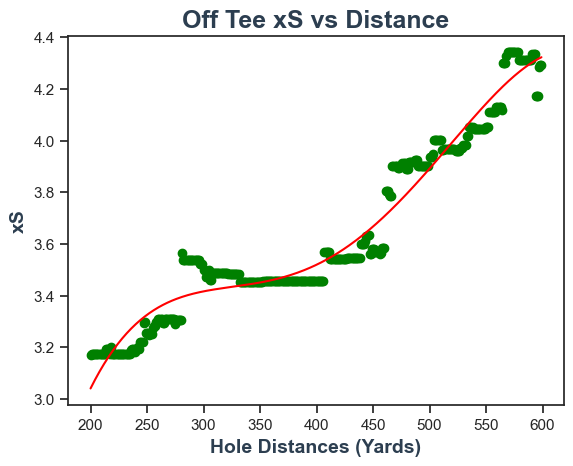

In [52]:
plt.scatter(list_of_distances, Tee_Predictions, color='green', label='Scatter Plot')

coefficients = np.polyfit(list_of_distances, Tee_Predictions, 4)
poly_line = np.poly1d(coefficients)
plt.plot(list_of_distances, poly_line(list_of_distances), color='red', label='Best Fit Line')
plt.xlabel('Hole Distances (Yards)', fontsize=14, fontweight='bold', color='#2c3e50')  # Dark blue for the label
plt.ylabel('xS', fontsize=14, fontweight='bold', color='#2c3e50')
plt.title('Off Tee xS vs Distance', fontsize=18, fontweight='bold', color='#2c3e50')  # Larger title with dark blue color

# Approach xS

In [53]:
approach_data = X_valid.iloc[88]

#fairway
Fairway_Predictions = []
list_of_distances = [round(x, 1) for x in range(0, 250)]
f = approach_data
f['lie_location']='Fairway'
input = f.to_frame().T

for i in list_of_distances:
    input['distance_to_pin'] = i
    preds = stack_model.predict(input)
    Fairway_Predictions.append(preds[0])

#rough
Rough_Predictions = []
f['lie_location']='Rough'
input = f.to_frame().T

for i in list_of_distances:
    input['distance_to_pin'] = i
    preds = stack_model.predict(input)
    Rough_Predictions.append(preds[0])

approach_data

lie_location             Rough
round                        4
par_value                    5
slope                 Downhill
elevation           Above Ball
lie                        NaN
distance_to_pin         309.08
dist_from_center           136
dist_from_edge             378
Name: 7445, dtype: object

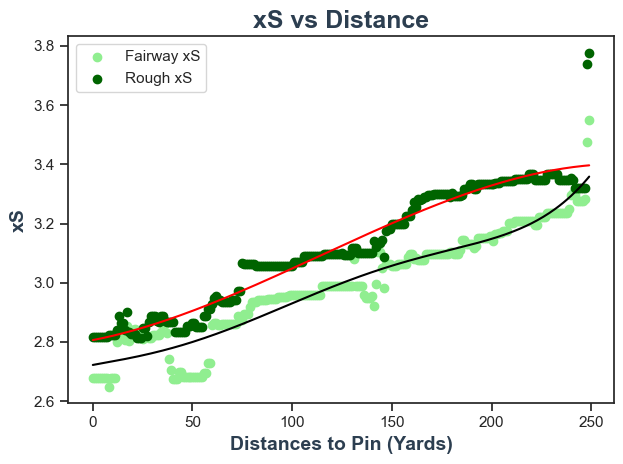

In [54]:
# Scatter plot for Fairway Predictions
plt.scatter(list_of_distances, Fairway_Predictions, color='lightgreen', label='Fairway xS')
coefficients = np.polyfit(list_of_distances, Fairway_Predictions, 5)
poly_line = np.poly1d(coefficients)
plt.plot(list_of_distances, poly_line(list_of_distances), color='black')

# Scatter plot for Rough Predictions
plt.scatter(list_of_distances, Rough_Predictions, color='darkgreen', label='Rough xS')
coefficients = np.polyfit(list_of_distances, Rough_Predictions, 3)
poly_line = np.poly1d(coefficients)
plt.plot(list_of_distances, poly_line(list_of_distances), color='red')

plt.xlabel('Distances to Pin (Yards)', fontsize=14, fontweight='bold', color='#2c3e50')  # Dark blue for the label
plt.ylabel('xS', fontsize=14, fontweight='bold', color='#2c3e50')
plt.title('xS vs Distance', fontsize=18, fontweight='bold', color='#2c3e50')  # Larger title with dark blue colo

# Show legend
plt.legend()
plt.tight_layout()


# Show the plot
plt.show()

In [55]:
# Create figure
p = figure(title="Expected Strokes",width=750, height=425)

# APPROACH
scatter_data = ColumnDataSource(data=dict(
    x=list_of_distances,
    y=Fairway_Predictions,
    y2=Rough_Predictions
))

p.scatter('x', 'y2', source=scatter_data, size=9, alpha=0.6, color= 'darkgreen', legend_label='Rough')
p.scatter('x', 'y', source=scatter_data, size=9, alpha=0.6, color='lightgreen', legend_label='Fairway')

coefficients = np.polyfit(list_of_distances, Fairway_Predictions, 3)
poly_line = np.poly1d(coefficients)
p.line(list_of_distances, poly_line(list_of_distances), color='black',line_width=3)

coefficients = np.polyfit(list_of_distances, Rough_Predictions, 3)
poly_line = np.poly1d(coefficients)
p.line(list_of_distances, poly_line(list_of_distances), color='red',line_width=3)


#STYLE
#p.title.text_font = "Helvetica"
p.xaxis.axis_label = 'Yards'
p.yaxis.axis_label = 'xS'
p.xaxis.axis_label_text_font_size = '18pt'
p.yaxis.axis_label_text_font_size = '18pt'
p.title.text_font_size = '25pt'
p.legend.location = "top_right"
p.y_range = Range1d(start = 2.47,end=3.2)  # Invert x-axis
p.x_range = Range1d(start=235, end=0)  # Invert x-axis 

# p.output_backend = "svg"
# export_svgs(p, filename="plotttt888y.svg")
# show(p)


# **Bunkers**

In [56]:
bunker_df = X_train[X_train['lie_location'] == 'Bunker']

bunker_test = bunker_df.iloc[4]

bunker_Predictions = []
list_of_bunker_distances = [round(x, 1) for x in range(7, 250)]
f = bunker_test
input = f.to_frame().T

for i in list_of_bunker_distances:
    input['distance_to_pin'] = i
    preds = stack_model.predict(input)
    bunker_Predictions.append(preds[0])


min_b = bunker_df['distance_to_pin'].min()
print(f'closest bunker shot is {min_b}')
min_b = bunker_df['distance_to_pin'].max()
print(f'furthest is {min_b}')
bunker_test


closest bunker shot is 7.194444444444445
furthest is 231.19444444444446


lie_location        Bunker
round                    4
par_value                5
slope                Level
elevation             With
lie                   Good
distance_to_pin       9.28
dist_from_center       366
dist_from_edge         122
Name: 7950, dtype: object

# save as svg
also put a flag at the end lol
https://stackoverflow.com/questions/34646270/how-do-i-work-with-images-in-bokeh-python


golf flag:
https://www.rawpixel.com/image/6210274/png-sticker-collage

throw in a tiger:
https://www.freepik.com/premium-psd/tiger-walking-isolated-transparent-background_45163181.htm

# get rid og 'hole' keep round and par value, add in binned distances and better ranges for each 5 shot types
# add in a range to zoom in bokeh style
# maybe start from 300 idk

In [57]:
# Create figure
p = figure(title="Expected Strokes",width=1500, height=850)

# APPROACH
scatter_data = ColumnDataSource(data=dict(
    x=list_of_distances,
    y=Fairway_Predictions,
    y2=Rough_Predictions
))
coefficients_fairway = np.polyfit(list_of_distances, Fairway_Predictions, 3)
poly_fairway = np.poly1d(coefficients_fairway)
coefficients_rough = np.polyfit(list_of_distances, Rough_Predictions, 3)
poly_rough = np.poly1d(coefficients_rough)
p.scatter('x', 'y', source=scatter_data, size=20, alpha=0.7, color=viridis(3)[1], legend_label='Fairway')
p.scatter('x', 'y2', source=scatter_data, size=20, alpha=0.7, color=viridis(3)[2], legend_label='Rough')



# OFF THE TEE
scatter_data = ColumnDataSource(data=dict(
    x=list_of_distances_tee,
    y=Tee_Predictions
))
coefficients_tee = np.polyfit(list_of_distances_tee, Tee_Predictions, 3)
poly_tee = np.poly1d(coefficients_tee)
p.scatter('x', 'y', source=scatter_data, size=20, alpha=0.4, color=viridis(3)[0], legend_label='Tee')



# # PUTTING
# scatter_data = ColumnDataSource(data=dict(
#     xp=list_of_putting_distances,
#     yp=putting_Predictions
# ))
# p.scatter('xp', 'yp', source=scatter_data, size=20, alpha=0.4, color=viridis(5)[3], legend_label='Putting')


# #nooo sample data so bad to work with
# #BUNKER
# scatter_data = ColumnDataSource(data=dict(
#     xp=list_of_bunker_distances,
#     yp=bunker_Predictions
# ))
# p.scatter('xp', 'yp', source=scatter_data, size=20, alpha=0.4, color='red', legend_label='Bunker')



#STYLE
p.title.text_font = "Helvetica"
p.xaxis.axis_label = 'Yards to Pin'
p.yaxis.axis_label = 'xS'
p.xaxis.axis_label_text_font_size = '12pt'
p.yaxis.axis_label_text_font_size = '12pt'
p.title.text_font_size = '20pt'
p.legend.location = "top_right"
p.x_range = Range1d(start=600, end=-10)  # Invert x-axis

show(p)
# export_png(grid, filename="P2F.png")


# **Final xSG vs True Score**

In [58]:
result_df['xS'] = 0


#approach
bunker_test = bunker_df.iloc[4]
f = bunker_test
input = f.to_frame().T

#green
putting_test = putting_X_valid.iloc[9]
f = putting_test
putting_input = f.to_frame().T

for index, row in result_df.iterrows():

    if row['lie_location'] == 'Green':

        putting_input['slope'] = row['slope']
        putting_input['elevation'] = row['elevation']
        putting_input['distance_to_pin'] = row['distance_to_pin']
        putting_input['distance_bins_putting'] = row['distance_bins_putting']
        putting_input['dist_from_edge'] = row['dist_from_edge']


        preds = stack_model_putting.predict(putting_input)
        result_df['xS'].iloc[index] = preds[0]

    if row['lie_location'] != 'Green':


        input['lie_location'] = row['lie_location']
        input['round'] = row['round']
        input['par_value'] = row['par_value']
        input['slope'] = row['slope']
        input['elevation'] = row['elevation']
        input['lie'] = row['lie']
        input['distance_to_pin'] = row['distance_to_pin']
        input['dist_from_center'] = row['dist_from_center']
        input['distance_bins'] = row['distance_bins']
        input['dist_from_edge'] = row['dist_from_edge']


        preds = stack_model.predict(input)
        result_df['xS'].iloc[index] = preds[0]

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^m

In [59]:
result_df['SG'] = result_df['xS'] - result_df['strokes_to_hole_out']


In [60]:
result_df

,player_id,last_name,round,hole,hole_score,par_value,yardage,shot,shot_type,num_of_strokes,...,dist_from_edge,lie_location,round_hole_combination,strokes_to_hole_out,next_lie_location,bad_strokes_to_hole_out_value_flag,distance_bins,distance_bins_putting,xS,SG
0,1810,Mickelson,1,1,4,4,424,1,S,1,...,126,Tee,1,4,Rough,False,400-650,,3.99,-0.01
1,1810,Mickelson,1,1,4,4,424,2,S,1,...,25,Rough,1,3,Green,False,0-150,,3.03,0.03
2,1810,Mickelson,1,1,4,4,424,3,S,1,...,199,Green,1,2,Green,False,0-150,6-14,2.01,0.01
3,1810,Mickelson,1,1,4,4,424,4,S,1,...,0,Green,1,1,Hole,False,0-150,1-1.5,1.00,0.00
4,1810,Mickelson,1,2,2,3,214,1,S,1,...,347,Tee,2,2,Green,False,200-300,,2.92,0.92
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8165,33141,Bradley,4,17,5,4,470,4,S,1,...,95,Green,71,2,Green,False,0-150,14-30,2.22,0.22
8166,33141,Bradley,4,17,5,4,470,5,S,1,...,0,Green,71,1,Hole,False,0-150,1.5-2,1.01,0.01
8167,33141,Bradley,4,18,3,3,235,1,S,1,...,294,Tee,72,3,Green,False,200-300,,3.09,0.09
8168,33141,Bradley,4,18,3,3,235,2,S,1,...,184,Green,72,2,Green,False,0-150,6-14,2.01,0.01


In [61]:
# Assuming result_df contains your DataFrame and 'SG' is the column name
hist, edges = np.histogram(result_df['SG'], bins=100)

# Find the index of the bin with the maximum frequency
max_freq_index = np.argmax(hist)

# Exclude the bin with the maximum frequency
hist = np.delete(hist, max_freq_index)
edges = np.delete(edges, max_freq_index)

# Create the figure
p = figure(title='Distribution of SG', background_fill_color="#f5f5f5")

# Plot the histogram
p.quad(top=hist, bottom=0, left=edges[:-1], right=edges[1:], fill_color=viridis_palette[180], line_color="#033649")

# Customize axes
p.xaxis.axis_label = 'SG'
p.yaxis.axis_label = 'Frequency'

# Add grid lines
p.xgrid.grid_line_color = None
p.ygrid.grid_line_alpha = 0.6
p.x_range.start = -1
p.x_range.end = 1

show(p)


In [62]:
result_df.to_csv('SG_golf.csv')

# Bin:

- putting
- [0,50] - rough and fairway for both
- [50,100] - rough and fairway for both
- [100,150] - rough and fairway for both
- [150, 200] - rough and fairway for both
- [200+] - rough and fairway for both
- Tee

# test before bin

In [63]:
result_df

,player_id,last_name,round,hole,hole_score,par_value,yardage,shot,shot_type,num_of_strokes,...,dist_from_edge,lie_location,round_hole_combination,strokes_to_hole_out,next_lie_location,bad_strokes_to_hole_out_value_flag,distance_bins,distance_bins_putting,xS,SG
0,1810,Mickelson,1,1,4,4,424,1,S,1,...,126,Tee,1,4,Rough,False,400-650,,3.99,-0.01
1,1810,Mickelson,1,1,4,4,424,2,S,1,...,25,Rough,1,3,Green,False,0-150,,3.03,0.03
2,1810,Mickelson,1,1,4,4,424,3,S,1,...,199,Green,1,2,Green,False,0-150,6-14,2.01,0.01
3,1810,Mickelson,1,1,4,4,424,4,S,1,...,0,Green,1,1,Hole,False,0-150,1-1.5,1.00,0.00
4,1810,Mickelson,1,2,2,3,214,1,S,1,...,347,Tee,2,2,Green,False,200-300,,2.92,0.92
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8165,33141,Bradley,4,17,5,4,470,4,S,1,...,95,Green,71,2,Green,False,0-150,14-30,2.22,0.22
8166,33141,Bradley,4,17,5,4,470,5,S,1,...,0,Green,71,1,Hole,False,0-150,1.5-2,1.01,0.01
8167,33141,Bradley,4,18,3,3,235,1,S,1,...,294,Tee,72,3,Green,False,200-300,,3.09,0.09
8168,33141,Bradley,4,18,3,3,235,2,S,1,...,184,Green,72,2,Green,False,0-150,6-14,2.01,0.01


In [64]:
result_df['last_name'].unique()

array(['Mickelson', 'Toms', 'Stricker', 'Singh', 'Senden', 'Jacobson',
       'Wilson', 'Howell III', 'Ogilvy', 'Baddeley', 'Rose', 'Kuchar',
       'Van Pelt', 'Donald', 'Choi', 'Scott', 'Yang', 'Mahan', 'Haas',
       'Byrd', 'Dufner', 'Watson', 'Reavie', 'Watney', 'Snedeker', 'Day',
       'Simpson', 'Johnson', 'Woodland', 'Bradley'], dtype=object)

In [65]:
Mickelson_df = result_df[result_df['last_name'] == 'Baddeley']
Mickelson_df.groupby('lie_location')['SG'].sum()

lie_location
Bunker     0.79
Fairway    5.42
Green     -0.02
Rough      6.53
Tee        9.20
Unknown   -0.75
Name: SG, dtype: float64

In [66]:
data_dict_v2 = {'categories': [
  ('Putting', 'Putting'),
('0-50', 'Fairway'),
  ('0-50', 'Rough'),
  ('50-100', 'Fairway'),
  ('50-100', 'Rough'),
  ('100-150', 'Fairway'),
  ('100-150', 'Rough'),
  ('150-200', 'Fairway'),
  ('150-200', 'Rough'),
  ('200+', 'Fairway'),
  ('200+', 'Rough'), 
  ('OTT', 'OTT')],
 'counts': [ -0.45,
 0.7643223410767481,
  0.618209806778764,
  0.31523852517676243,
  1.685532577533778,
  4.008802965841829,
  3.05527278681565,
  1.2868530628310997,
  -0.7284675091600565,
  -0.24459081236688984,
  1.309407203030625 ,
  9.19]}

In [67]:
len(data_dict_v2['categories'])

12

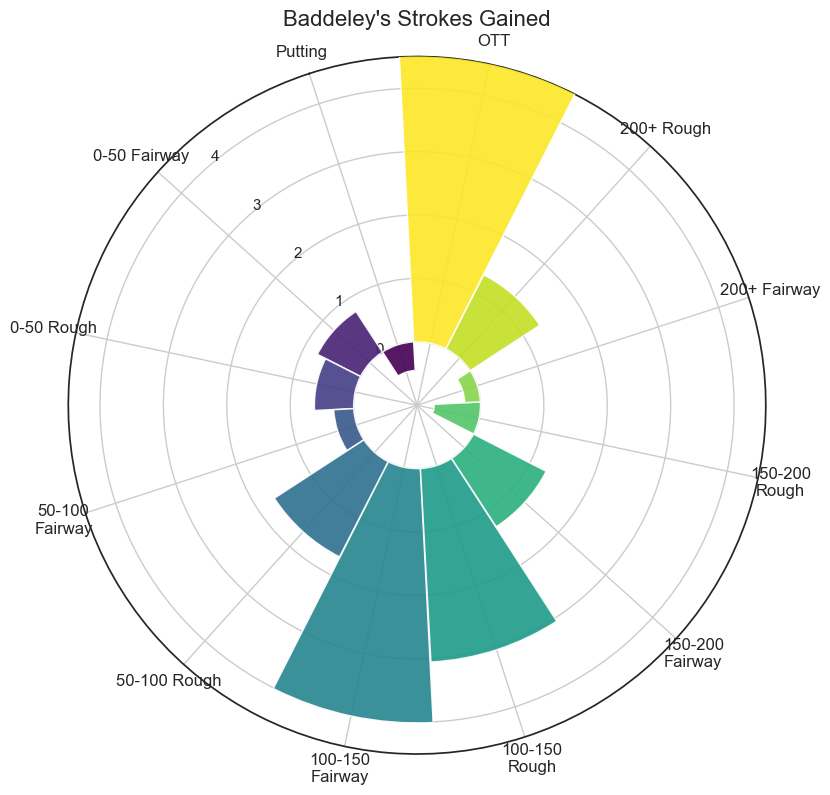

In [68]:
# Fake data
ANGLES = np.linspace(0, 2*np.pi, 12, endpoint=False)
LENGTHS =  [ -0.45,
 0.7643223410767481,
  0.618209806778764,
  0.31523852517676243,
  1.685532577533778,
  4.008802965841829,
  3.05527278681565,
  1.2868530628310997,
  -0.7284675091600565,
  -0.24459081236688984,
  1.309407203030625 ,
  9.19]
MEAN_GAIN =  [ -0.45,
 0.7643223410767481,
  0.618209806778764,
  0.31523852517676243,
  1.685532577533778,
  4.008802965841829,
  3.05527278681565,
  1.2868530628310997,
  -0.7284675091600565,
  -0.24459081236688984,
  1.309407203030625 ,
  9.19]
REGION = ['Putting',
 '0-50 Fairway',
 '0-50 Rough',
 '50-100 Fairway',
 '50-100 Rough',
 '100-150 Fairway',
 '100-150 Rough',
 '150-200 Fairway',
 '150-200 Rough',
 '200+ Fairway',
 '200+ Rough',
 'OTT']
VIRIDIS = get_cmap('viridis')  # Get the viridis colormap object
GREY12 = 'gray'

# Some layout stuff ----------------------------------------------
# Initialize layout in polar coordinates
fig, ax = plt.subplots(figsize=(9, 12.6), subplot_kw={"projection": "polar"})

# Set background color to white, both axis and figure.
fig.patch.set_facecolor("white")
#ax.set_facecolor("white")

ax.set_theta_offset(1.2 * np.pi / 2)
ax.set_ylim(-1, 4.5)

# Add geometries to the plot -------------------------------------
# See the zorder to manipulate which geometries are on top

# Add bars to represent the cumulative track lengths
colors = [VIRIDIS(i) for i in np.linspace(0, 1, 12)]
bars = ax.bar(ANGLES, LENGTHS, color=colors, alpha=0.9, width=0.52, zorder=12)

# Add dashed vertical lines. These are just references
# ax.vlines([0,90, 45, 49], -10, 10, color=GREY12, ls=(0, (4, 4)), zorder=11)

# # Add dots to represent the mean gain
# ax.scatter(ANGLES, MEAN_GAIN, s=60, color=GREY12, zorder=11)


# Add labels for the regions -------------------------------------
# Note the 'wrap()' function.
# The '5' means we want at most 5 consecutive letters in a word, 
# but the 'break_long_words' means we don't want to break words 
# longer than 5 characters.
REGION = ["\n".join(wrap(r, 12, break_long_words=False)) for r in REGION]

# Set the labels
ax.set_xticks(ANGLES)
ax.set_xticklabels(REGION, size=12)
plt.title("Baddeley's Strokes Gained", fontsize=16)
# Add color legend
# legend_labels = ["Region 1", "Region 2", "Region 3", "Region 4", "Region 5"]
# plt.legend(handles=bars, labels=legend_labels, loc="upper right", title="Regions", fontsize=10)

plt.show()


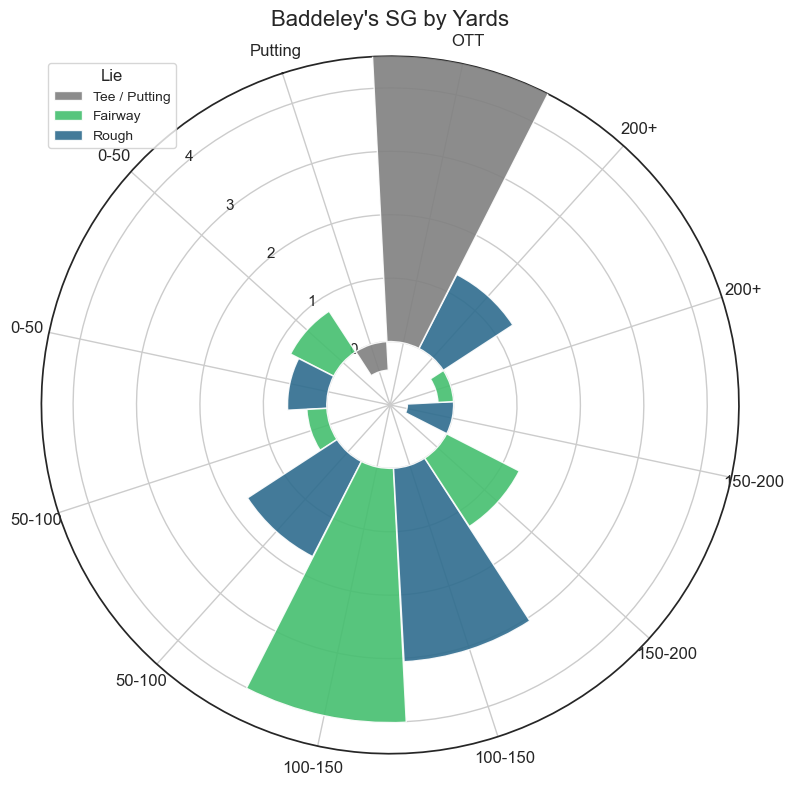

In [69]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
from textwrap import wrap

# Fake data
ANGLES = np.linspace(0, 2*np.pi, 12, endpoint=False)
LENGTHS =  [ -0.45,
 0.7643223410767481,
  0.618209806778764,
  0.31523852517676243,
  1.685532577533778,
  4.008802965841829,
  3.05527278681565,
  1.2868530628310997,
  -0.7284675091600565,
  -0.24459081236688984,
  1.309407203030625 ,
  9.19]
MEAN_GAIN =  [ -0.45,
 0.7643223410767481,
  0.618209806778764,
  0.31523852517676243,
  1.685532577533778,
  4.008802965841829,
  3.05527278681565,
  1.2868530628310997,
  -0.7284675091600565,
  -0.24459081236688984,
  1.309407203030625 ,
  9.19]
REGION = ['Putting',
 '0-50',
 '0-50',
 '50-100',
 '50-100',
 '100-150',
 '100-150',
 '150-200',
 '150-200',
 '200+',
 '200+',
 'OTT']

VIRIDIS = get_cmap('viridis')  # Get the viridis colormap object
GREY12 = 'gray'

# Some layout stuff ----------------------------------------------
# Initialize layout in polar coordinates
fig, ax = plt.subplots(figsize=(9, 12.6), subplot_kw={"projection": "polar"})

# Set background color to white, both axis and figure.
fig.patch.set_facecolor("white")
#ax.set_facecolor("white")

ax.set_theta_offset(1.2 * np.pi / 2)
ax.set_ylim(-1, 4.5)

# Add geometries to the plot -------------------------------------
# See the zorder to manipulate which geometries are on top

# Define custom colors for bars
custom_colors = ['gray', viridis(256)[180], viridis(256)[90], viridis(256)[180], viridis(256)[90], viridis(256)[180], viridis(256)[90], viridis(256)[180], viridis(256)[90], viridis(256)[180], viridis(256)[90], 'gray']

# Add bars to represent the cumulative track lengths
bars = ax.bar(ANGLES, LENGTHS, color=custom_colors, alpha=0.9, width=0.52, zorder=12)

# Add labels for the regions -------------------------------------
# Note the 'wrap()' function.
# The '5' means we want at most 5 consecutive letters in a word, 
# but the 'break_long_words' means we don't want to break words 
# longer than 5 characters.
REGION = ["\n".join(wrap(r, 12, break_long_words=False)) for r in REGION]

# Set the labels
ax.set_xticks(ANGLES)
ax.set_xticklabels(REGION, size=12)
plt.title("Baddeley's SG by Yards", fontsize=16)

legend_labels = ["Tee / Putting", "Fairway", "Rough"]
plt.legend(handles=bars, labels=legend_labels, loc="upper left", title="Lie", fontsize=10)


plt.show()


In [70]:
Mickelson_df.groupby('lie_location')['SG'].mean()

lie_location
Bunker     0.07
Fairway    0.15
Green     -0.00
Rough      0.16
Tee        0.13
Unknown   -0.75
Name: SG, dtype: float64

<Axes: xlabel='SG', ylabel='Density'>

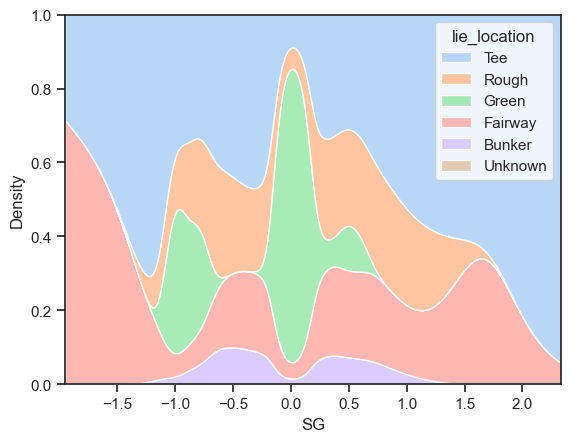

In [71]:
sns.kdeplot(data=Mickelson_df, x="SG", hue="lie_location", multiple="fill")


<Axes: xlabel='SG', ylabel='Density'>

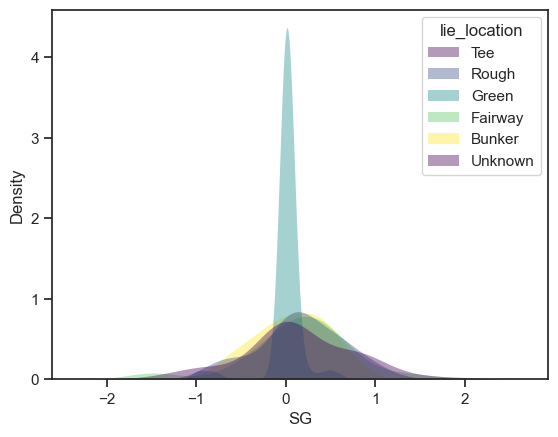

In [72]:
sns.kdeplot(
   data=Mickelson_df, x="SG", hue="lie_location",
   fill=True, common_norm=False, palette=viridis(5),
   alpha=.4, linewidth=0,
)

In [75]:
# from bokeh.plotting import figure, show
# from bokeh.io import output_notebook
# from bokeh.transform import factor_cmap
# from bokeh.models import Legend
# from bokeh.palettes import Viridis
# from scipy.stats import gaussian_kde
# import numpy as np

# # Create a Bokeh figure
# p = figure(title="Density Plot of SG by Lie Location", background_fill_color="#fafafa")

# # Define colors
# colors = factor_cmap('lie_location', palette=Viridis[5], factors=Mickelson_df['lie_location'].unique())

# # Define x range based on data
# x_range = (min(Mickelson_df['SG']), max(Mickelson_df['SG']))

# # Iterate over unique lie locations
# for i, lie_loc in enumerate(Mickelson_df['lie_location'].unique()):
#     # Filter data for the current lie location
#     subset = Mickelson_df[Mickelson_df['lie_location'] == lie_loc]['SG']
    
#     # Perform Kernel Density Estimation
#     kde = gaussian_kde(subset)
#     x = np.linspace(min(subset), max(subset), 100)
#     y = kde(x)
    
#     # Plot KDE
#     p.line(x, y, line_width=2, legend_label=lie_loc, color=Viridis[5][i])

#     #p.patch(np.append(x, x[::-1]), np.append(y, np.zeros_like(y[::-1])), color=Viridis[5][i], alpha=0.4, line_color=None)


# # Add legend
# legend = Legend(items=[(lie_loc, [p.renderers[i]]) for i, lie_loc in enumerate(Mickelson_df['lie_location'].unique())])
# p.add_layout(legend)

# # Customize plot
# p.xaxis.axis_label = 'SG'
# p.yaxis.axis_label = 'Density'
# p.x_range.start, p.x_range.end = x_range

# # Show plot
# output_notebook()
# show(p)


In [76]:
bins = [0, 50, 100, 150, 200, float('inf')]
labels = ['0-50', '50-100', '100-150', '150-200', '200+']

# Apply binning to the DataFrame
result_df['SG_bins'] = pd.cut(result_df['distance_to_pin'], bins=bins, labels=labels, right=False)

# Fill missing values with empty string
result_df['SG_bins'] = result_df['SG_bins'].cat.add_categories([''])
result_df['SG_bins'].fillna('', inplace=True)

In [78]:
result_df

,player_id,last_name,round,hole,hole_score,par_value,yardage,shot,shot_type,num_of_strokes,...,lie_location,round_hole_combination,strokes_to_hole_out,next_lie_location,bad_strokes_to_hole_out_value_flag,distance_bins,distance_bins_putting,xS,SG,SG_bins
0,1810,Mickelson,1,1,4,4,424,1,S,1,...,Tee,1,4,Rough,False,400-650,,3.99,-0.01,200+
1,1810,Mickelson,1,1,4,4,424,2,S,1,...,Rough,1,3,Green,False,0-150,,3.03,0.03,100-150
2,1810,Mickelson,1,1,4,4,424,3,S,1,...,Green,1,2,Green,False,0-150,6-14,2.01,0.01,0-50
3,1810,Mickelson,1,1,4,4,424,4,S,1,...,Green,1,1,Hole,False,0-150,1-1.5,1.00,0.00,0-50
4,1810,Mickelson,1,2,2,3,214,1,S,1,...,Tee,2,2,Green,False,200-300,,2.92,0.92,200+
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8165,33141,Bradley,4,17,5,4,470,4,S,1,...,Green,71,2,Green,False,0-150,14-30,2.22,0.22,0-50
8166,33141,Bradley,4,17,5,4,470,5,S,1,...,Green,71,1,Hole,False,0-150,1.5-2,1.01,0.01,0-50
8167,33141,Bradley,4,18,3,3,235,1,S,1,...,Tee,72,3,Green,False,200-300,,3.09,0.09,200+
8168,33141,Bradley,4,18,3,3,235,2,S,1,...,Green,72,2,Green,False,0-150,6-14,2.01,0.01,0-50


In [79]:
Mickelson_df.groupby(['lie_location'])['SG'].sum()

lie_location
Bunker     0.79
Fairway    5.42
Green     -0.02
Rough      6.53
Tee        9.20
Unknown   -0.75
Name: SG, dtype: float64

In [80]:
Mickelson_df = result_df[result_df['last_name'] == 'Baddeley']

data = Mickelson_df.groupby(['SG_bins','lie_location'])['SG'].sum()
data

SG_bins  lie_location
0-50     Bunker          0.62
         Fairway         0.82
         Green          -0.02
         Rough           1.07
         Tee             0.00
         Unknown         0.00
50-100   Bunker          0.00
         Fairway        -0.09
         Green           0.00
         Rough           1.45
         Tee             0.00
         Unknown         0.00
100-150  Bunker         -0.07
         Fairway         3.81
         Green           0.00
         Rough           3.23
         Tee             0.00
         Unknown         0.00
150-200  Bunker          0.23
         Fairway         1.04
         Green           0.00
         Rough          -0.71
         Tee            -1.74
         Unknown         0.00
200+     Bunker          0.00
         Fairway        -0.16
         Green           0.00
         Rough           1.49
         Tee            10.94
         Unknown        -0.75
         Bunker          0.00
         Fairway         0.00
         Green    

In [81]:
test_df = result_df

In [82]:
test_df['SG_bins'] = test_df['SG_bins'].cat.add_categories('Green')  # Add 'Green' category


In [83]:
test_df['SG_bins'] = test_df['SG_bins'].cat.add_categories('Tee')  # Add 'Green' category


In [84]:
test_df.loc[test_df['lie_location'].str.contains('Green', case=False), 'SG_bins'] = 'Green'
test_df.loc[test_df['lie_location'].str.contains('Tee', case=False), 'SG_bins'] = 'Tee'                        

In [85]:
Baddeley_df = test_df[test_df['last_name'] == 'Baddeley']

data = Baddeley_df.groupby(['SG_bins','lie_location'])['SG'].sum()
data

SG_bins  lie_location
0-50     Bunker          0.62
         Fairway         0.82
         Green           0.00
         Rough           1.07
         Tee             0.00
         Unknown         0.00
50-100   Bunker          0.00
         Fairway        -0.09
         Green           0.00
         Rough           1.45
         Tee             0.00
         Unknown         0.00
100-150  Bunker         -0.07
         Fairway         3.81
         Green           0.00
         Rough           3.23
         Tee             0.00
         Unknown         0.00
150-200  Bunker          0.23
         Fairway         1.04
         Green           0.00
         Rough          -0.71
         Tee             0.00
         Unknown         0.00
200+     Bunker          0.00
         Fairway        -0.16
         Green           0.00
         Rough           1.49
         Tee             0.00
         Unknown        -0.75
         Bunker          0.00
         Fairway         0.00
         Green    

In [86]:
from bokeh.models import ColumnDataSource, FactorRange
from bokeh.palettes import MediumContrast3, viridis
from bokeh.plotting import figure, show
from bokeh.transform import factor_cmap
import pandas as pd

# Assuming 'Mickelson_df' is your DataFrame containing the grouped data
# Perform the groupby operation
grouped_data = data # Mickelson_df.groupby(['SG_bins', 'lie_location'])['SG'].sum()

# Convert the grouped data into a dictionary suitable for plotting
data_dict = {
    'categories': [],
    'counts': []
}

for category, count in grouped_data.items():
    data_dict['categories'].append(category)
    data_dict['counts'].append(count)

# Create an empty list to store indices to delete
indices_to_delete = []

# Loop through the categories and counts
for i in range(len(data_dict['categories'])):
    # Check if the lie location is 'Bunker' or count is 0
    if data_dict['categories'][i][1] == 'Bunker' or data_dict['counts'][i] == 0:
        # Add the index to the list of indices to delete
        indices_to_delete.append(i)

# Remove the entries with the specified indices
for index in sorted(indices_to_delete, reverse=True):
    if index < len(data_dict['categories']) and index < len(data_dict['counts']):
        del data_dict['categories'][index]
        del data_dict['counts'][index]

# Print or return data_dict to verify the changes
data_dict

{'categories': [('0-50', 'Fairway'),
  ('0-50', 'Rough'),
  ('50-100', 'Fairway'),
  ('50-100', 'Rough'),
  ('100-150', 'Fairway'),
  ('100-150', 'Rough'),
  ('150-200', 'Fairway'),
  ('150-200', 'Rough'),
  ('200+', 'Fairway'),
  ('200+', 'Rough'),
  ('200+', 'Unknown'),
  ('Green', 'Green'),
  ('Tee', 'Tee')],
 'counts': [0.821052006211171,
  1.0694935976308741,
  -0.08895569282479476,
  1.4499291993494943,
  3.8096149945396287,
  3.2251006437419285,
  1.0387435287879527,
  -0.7088457315171985,
  -0.160524714336022,
  1.493801667766144,
  -0.7539175827116109,
  -0.021460317190183043,
  9.199468812135947]}

In [87]:
from bokeh.palettes import viridis

data_dict_v2 = {'categories': [
  ('Putting', 'Putting'),
('0-50', 'Fairway'),
  ('0-50', 'Rough'),
  ('50-100', 'Fairway'),
  ('50-100', 'Rough'),
  ('100-150', 'Fairway'),
  ('100-150', 'Rough'),
  ('150-200', 'Fairway'),
  ('150-200', 'Rough'),
  ('200+', 'Fairway'),
  ('200+', 'Rough'), 
  ('OTT', 'OTT')],
 'counts': [ -0.45,
 0.7643223410767481,
  0.618209806778764,
  0.31523852517676243,
  1.685532577533778,
  4.008802965841829,
  3.05527278681565,
  1.2868530628310997,
  -0.7284675091600565,
  -0.24459081236688984,
  1.309407203030625 ,
  9.19]}


# Create a ColumnDataSource
source = ColumnDataSource(data=data_dict_v2)
categories = grouped_data.index.levels[1]

# Create the figure
p = figure(x_range=FactorRange(*data_dict_v2['categories']), height=600,width=1000, title="Baddeley's SG by Shot Type",
           toolbar_location=None, tools="", output_backend="svg")

custom_colors = [viridis(256)[180],  viridis(256)[180], viridis(256)[180],viridis(256)[90]]


# Plot the data
p.vbar(x='categories', top='counts', width=0.9, source=source, line_color="white",
       fill_color=factor_cmap('categories', palette=custom_colors, factors=categories, start=1, end=2))

# Customize the plot
p.y_range.start = -1
p.y_range.end = 6

p.x_range.range_padding = 0.1
p.xaxis.major_label_orientation = 1
p.xgrid.grid_line_color = None
p.xaxis.major_label_text_font_size = '10pt' 

p.xaxis.axis_label = 'Shot Type'
p.yaxis.axis_label = 'SG'
p.xaxis.axis_label_text_font_size = '12pt'  # Increase x-axis label font size
p.yaxis.axis_label_text_font_size = '12pt'
p.title.text_font_size = '18pt'

# Show the plot
show(p)

#save as SVG
p.output_backend = "svg"
export_svgs(p, filename="bad_sg_5.svg")

['bad_sg_5.svg']

In [88]:
categories

Index(['Bunker', 'Fairway', 'Green', 'Rough', 'Tee', 'Unknown'], dtype='object', name='lie_location')

In [89]:
data_dict_v2['categories']

[('Putting', 'Putting'),
 ('0-50', 'Fairway'),
 ('0-50', 'Rough'),
 ('50-100', 'Fairway'),
 ('50-100', 'Rough'),
 ('100-150', 'Fairway'),
 ('100-150', 'Rough'),
 ('150-200', 'Fairway'),
 ('150-200', 'Rough'),
 ('200+', 'Fairway'),
 ('200+', 'Rough'),
 ('OTT', 'OTT')]

In [90]:
categories = [category[0] for category in data_dict_v2['categories']]
categories

['Putting',
 '0-50',
 '0-50',
 '50-100',
 '50-100',
 '100-150',
 '100-150',
 '150-200',
 '150-200',
 '200+',
 '200+',
 'OTT']

In [91]:
from bokeh.transform import factor_cmap
from bokeh.models import ColumnDataSource, FactorRange
from bokeh.plotting import figure, show
from bokeh.palettes import viridis

data_dict_v2 = {'categories': [
    ('Putting', 'Putting'),
    ('0-50', 'Fairway'),
    ('0-50', 'Rough'),
    ('50-100', 'Fairway'),
    ('50-100', 'Rough'),
    ('100-150', 'Fairway'),
    ('100-150', 'Rough'),
    ('150-200', 'Fairway'),
    ('150-200', 'Rough'),
    ('200+', 'Fairway'),
    ('200+', 'Rough'),
    ('OTT', 'OTT')],
    'counts': [-0.45,
               0.7643223410767481,
               0.618209806778764,
               0.31523852517676243,
               1.685532577533778,
               4.008802965841829,
               3.05527278681565,
               1.2868530628310997,
               -0.7284675091600565,
               -0.24459081236688984,
               1.309407203030625,
               9.19]}

# Create a ColumnDataSource
source = ColumnDataSource(data=data_dict_v2)
categories = [category[0] for category in data_dict_v2['categories']]

# Create the figure
p = figure(x_range=FactorRange(*data_dict_v2['categories']), height=900, width=1800, title="SG by Shot Type",
           toolbar_location=None, tools="", output_backend="svg")

palette = viridis(70)

# Plot the data
p.vbar(x='categories', top='counts', width=0.9, source=source, line_color="white",
       fill_color=factor_cmap('categories', palette=palette, factors=categories, start=1, end=2))

# Customize the plot
p.y_range.start = -1
p.y_range.end = 6

p.x_range.range_padding = 0.1
p.xaxis.major_label_orientation = 1
p.xgrid.grid_line_color = None

p.xaxis.axis_label = 'Shot Type'
p.yaxis.axis_label = 'SG'
p.xaxis.axis_label_text_font_size = '18pt'  # Increase x-axis label font size
p.yaxis.axis_label_text_font_size = '18pt'
p.title.text_font_size = '25pt'

# Show the plot
show(p)

# Save as SVG
# export_svgs(p, filename="plot.svg")  # You can uncomment this line to save the plot as SVG


In [92]:
from bokeh.models import ColumnDataSource, FactorRange
from bokeh.plotting import figure, show
from bokeh.transform import factor_cmap
from bokeh.palettes import viridis

data_dict_v2 = {
    'categories': [
        ('Putting', 'Putting'),
        ('0-50', 'Fairway'),
        ('0-50', 'Rough'),
        ('50-100', 'Fairway'),
        ('50-100', 'Rough'),
        ('100-150', 'Fairway'),
        ('100-150', 'Rough'),
        ('150-200', 'Fairway'),
        ('150-200', 'Rough'),
        ('200+', 'Fairway'),
        ('200+', 'Rough'),
        ('OTT', 'OTT')
    ],
    'counts': [-0.45, 0.7643223410767481, 0.618209806778764, 0.31523852517676243, 1.685532577533778,
               4.008802965841829, 3.05527278681565, 1.2868530628310997, -0.7284675091600565, -0.24459081236688984,
               1.309407203030625, 9.19]
}

# Create a ColumnDataSource
source = ColumnDataSource(data=data_dict_v2)
categories = [category[0] for category in data_dict_v2['categories']]

# Create the figure
p = figure(x_range=FactorRange(*data_dict_v2['categories']), height=900, width=1800, title="SG by Shot Type",
           toolbar_location=None, tools="", output_backend="svg")

# Set a single color for all bars
color = "#1f77b4"  # You can change this to any color you like

# Plot the data
p.vbar(x='categories', top='counts', width=0.9, source=source, line_color="white", fill_color=color)

# Customize the plot
p.y_range.start = -1
p.y_range.end = 6

p.x_range.range_padding = 0.1
p.xaxis.major_label_orientation = 1
p.xgrid.grid_line_color = None

p.xaxis.axis_label = 'Shot Type'
p.yaxis.axis_label = 'SG'
p.xaxis.axis_label_text_font_size = '18pt'  # Increase x-axis label font size
p.yaxis.axis_label_text_font_size = '18pt'
p.title.text_font_size = '25pt'

# Show the plot
show(p)

# Save as SVG
# export_svgs(p, filename="plot.svg")  # You can uncomment this line to save the plot as SVG


In [93]:
from bokeh.models import ColumnDataSource, FactorRange
from bokeh.plotting import figure, show
from bokeh.transform import factor_cmap

data_dict_v2 = {
    'categories': [
        ('Putting', 'Putting'),
        ('0-50', 'Fairway'),
        ('0-50', 'Rough'),
        ('50-100', 'Fairway'),
        ('50-100', 'Rough'),
        ('100-150', 'Fairway'),
        ('100-150', 'Rough'),
        ('150-200', 'Fairway'),
        ('150-200', 'Rough'),
        ('200+', 'Fairway'),
        ('200+', 'Rough'),
        ('OTT', 'OTT')
    ],
    'counts': [-0.45, 0.7643223410767481, 0.618209806778764, 0.31523852517676243, 1.685532577533778,
               4.008802965841829, 3.05527278681565, 1.2868530628310997, -0.7284675091600565, -0.24459081236688984,
               1.309407203030625, 9.19]
}

# Create a ColumnDataSource
source = ColumnDataSource(data=data_dict_v2)
categories = [category[0] for category in data_dict_v2['categories']]

# Create the figure
p = figure(x_range=FactorRange(*data_dict_v2['categories']), height=900, width=1800, title="SG by Shot Type",
           toolbar_location=None, tools="", output_backend="svg")

# Define custom color palette
custom_palette = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f']

# Plot the data using custom color palette
p.vbar(x='categories', top='counts', width=0.9, source=source, line_color="white",
       fill_color=factor_cmap('categories', palette=custom_palette, factors=categories, start=1, end=2))

# Customize the plot
p.y_range.start = -1
p.y_range.end = 6

p.x_range.range_padding = 0.1
p.xaxis.major_label_orientation = 1
p.xgrid.grid_line_color = None

p.xaxis.axis_label = 'Shot Type'
p.yaxis.axis_label = 'SG'
p.xaxis.axis_label_text_font_size = '18pt'  # Increase x-axis label font size
p.yaxis.axis_label_text_font_size = '18pt'
p.title.text_font_size = '25pt'

# Show the plot
show(p)

# Save as SVG
# export_svgs(p, filename="plot.svg")  # You can uncomment this line to save the plot as SVG


# fit a normal curve of each shot type to show further away shots have a bigger standard deviation